In [1]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
import os

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize



from scipy.stats import mannwhitneyu    
from xgboost import XGBClassifier
import random
from sklearn.model_selection import KFold


# caculating_10_important_features
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
# sig_data = DATA.reshape(DATA.shape[0], -1)
def train_model_using_kfold(data, label, model, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True)
    result = []

    # Loop over each train/test split
    for train_index, test_index in kf.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result)

def train_model_using_loocv_with_nested_cv(data, label, model):
    loo = LeaveOneOut()
    result = []

    # Loop over each train/test split
    for train_index, test_index in loo.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier using 5-fold cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5)

        # Print the accuracy scores for each fold
        for fold, score in enumerate(scores):
            print(f"Fold {fold+1} Accuracy: {score}")

        # Calculate the mean accuracy across all folds
        mean_accuracy = np.mean(scores)
        print(f"Mean Accuracy: {mean_accuracy}")
        
        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result), model
def train_model_using_loocv(data, label, model):
    loo = LeaveOneOut()
    result = []

    # Loop over each train/test split
    for train_index, test_index in loo.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result), model

stats_method = 'mannwhitneyu' # 'ranksums' or 'mannwhitneyu'
def zero_diagnonal(arr):
    # Loop over the first and last dimension
    for i in range(arr.shape[0]):  # Loop over subjects
        for j in range(arr.shape[-1]):  # Loop over views
            np.fill_diagonal(arr[i, :, :, j], 0)
    return arr


def return_significant_FCvalue(adj, labels):
    adj = zero_diagnonal(adj)
    hc_adj = adj[np.where(labels==1)]
    md_adj = adj[np.where(labels==0)]
    count = 0

    num_view = adj.shape[-1]
    p_view = np.zeros((52,52,num_view))
    effect_size = np.zeros((52,52,num_view))
    stats = np.zeros((52,52,num_view))
    for view in range(num_view):
        for seed in range(52):
            for target in range(52):
                hc_val = hc_adj[:, seed, target, view]
                md_val = md_adj[:, seed, target, view]
                if stats_method == 'mannwhitneyu':
                    stat, p1 = mannwhitneyu(hc_val,md_val)

                else:
                    raise ValueError('stats_method should be mannwhitneyu or ranksums')
                p_view[seed, target, view] = p1
                stats[seed, target, view] = stat
    
    adj = adj.reshape(adj.shape[0], -1)
    p_view = p_view.reshape(-1)
    return adj[:, p_view<0.05]

def get_activity_start_time(data, index_start):
    gradient = np.gradient(data)
    max_gradient = np.argmax(gradient[0:int(index_start*1.2)])  # 0:index_start*4 # current index_start = 400,
    if max_gradient <= index_start:
        max_gradient = index_start
    return max_gradient


"""
Calulate the left slope based on the data sample time from activity_start_time and  activity_start_time + task_duration//2
"""


def get_left_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start: activity_start+task_duration//2]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
Calulate the right slope based on the data sample time from activity_start_time + task_duration//2 and activity_start_time + task_duration  
"""


def get_right_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start+task_duration//2: activity_start+task_duration]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
For calculating FWHM
"""


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def get_FWHM(y_values, activity_start, task_duration):
    # make sure the peak value is situated in the task duration period
    task = y_values[activity_start:activity_start+task_duration]
    max_task = np.max(task)  # Find the maximum y value
    half_max_y = max_task / 2.0
    max_index_task = np.argmax(task)
    # if max_index_task is in the first two values, set left_index to 0
    if max_index_task <= 1:
        left_index = 0
    else:
        left_index = find_nearest(y_values[:max_index_task], half_max_y)
    # if max_index_task is in the last two values, set right_index to the last value
    if max_index_task >= activity_start+task_duration-1:
        right_index = task_duration-1
    else:
        right_index = find_nearest(
            y_values[max_index_task:], half_max_y) + max_index_task

    return right_index - left_index


"""Get all 10 features"""


def get_10_features(hbo, index_start, task_duration):
    feature_shape = hbo.shape[:2]
    # Feature 1 mean
    mean = np.mean(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 2 variance
    variance = np.std(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 3 activity_start_time
    activity_start_time = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start_time[sub, ch] = get_activity_start_time(
                hbo[sub, ch], index_start=index_start)

    # # Feature 4 left_slope
    left_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            left_slope[sub, ch] = get_left_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)
    # # Feature 5  right_slope
    right_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            right_slope[sub, ch] = get_right_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)

    # # Feature 6 kurtosis
    kurt = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            kurt[sub, ch] = kurtosis(hbo[sub, ch])
    # There might be some nan in kurtosis calucaltion because of all 0-value array
    kurt = np.nan_to_num(kurt)

    # # Feature 7 skewness
    skewness = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            skewness[sub, ch] = skew(hbo[sub, ch])
    # There might be some nan in skewness calucaltion because of all 0-value array
    skewness = np.nan_to_num(skewness)

    # # Feature 8 area under the curve AUC Based on the sample time from activity_start_time + task_duration
    AUC = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            AUC[sub, ch] = np.sum(
                hbo[sub, ch][activity_start:activity_start+task_duration])
    # for sub in range(10):
    #     plt.plot(AUC[sub])

    # # Feature 9 full width half maximum (FWHM)
    # FWHM
    FWHM = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            FWHM[sub, ch] = get_FWHM(
                hbo[sub, ch], activity_start, task_duration)
    # for sub in range(10):
    #     plt.plot(FWHM[sub])

    # # Feature 10 peak
    peak = np.max(hbo, axis=2)

    features = np.concatenate((mean, variance, activity_start_time,
                              left_slope, right_slope, kurt, skewness, AUC, FWHM, peak), axis=1)

    return features

def get_significant_feature(data, labels):
    hc_adj = data[np.where(labels==1)]
    md_adj = data[np.where(labels==0)]
    count = 0

    p_view = np.zeros((hc_adj.shape[1:]))
    for view in range(p_view.shape[-1]):
        hc_val = hc_adj[:, view]
        mdd_val = md_adj[:, view]
        _, p1 = mannwhitneyu(hc_val,mdd_val)
        p_view[view] = p1
    data = data.reshape(data.shape[0], -1)
    p_view = p_view.reshape(-1)
    data = data[:, p_view<0.05]
    return data 


def get_metrics(y_true, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 明确指定labels参数
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # 现在cm是一个2x2矩阵，即使数据只包含一个类别
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1

def print_md_table(model_name, set, metrics):
    print()
    print('| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |')
    print('|------------|----------|----------|-------------|-------------|----------|')
    print(f'| {model_name} | {set} |', end = '')
    for i in range(4):
        print(f" {metrics[i]:.4f} |", end = '')
    print()
    print(''*10)

def average_signal_and_reshape(data, numof_avgpoint=10):
    try:
        assert len(data.shape) == 3, "wrong data shape, it should be like (n_sample, n_channel, n_timepoint)"
        print("The data shape length is 3.")
    except AssertionError as error:
        print(error)
    totalpoint = data.shape[-1] // numof_avgpoint
    data = data[...,:int(totalpoint*numof_avgpoint)]
    data = np.reshape(data, (data.shape[0], 52, -1, 10))
    data = np.mean(data, axis=-1)
    data = np.reshape(data, (data.shape[0], -1))
    return data


In [2]:
# load the pretreatment data 
from scipy.stats import zscore
pretreatment_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/hb_data.npy'
label_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/label.npy'
demo_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/demographic_data.npy'
pretreatment_data = np.load(pretreatment_path)
pretreatment_label = np.load(label_path)
pretreatment_demo = np.load(demo_path, allow_pickle=True)
print(f'pretreatment_data shape: {pretreatment_data.shape}')
print(f'pretreatment_label shape: {pretreatment_label.shape}') 

pretreatment_data shape: (65, 52, 2502)
pretreatment_label shape: (65,)


In [7]:
def remove_nan_for_demographic_data(demographic_data):
    for index, sub_value in enumerate(demographic_data):
        try: 
            demographic_data[index] = sub_value.astype(int)
            pass
        except:
            for i, v in enumerate(sub_value):
                if type(v) is not int:
                    print('index:', i, 'value:', v)
                    sub_value[i] = 1
                    print('index:', i, 'fixed - value:', sub_value[i])
                    print('there should be a subject whose handedness is empty, the above steps set it to be 1')
            demographic_data[index] = sub_value.astype(int)

    demographic_data = demographic_data.astype(int)
    return demographic_data

updated_demo = remove_nan_for_demographic_data(pretreatment_demo)
updated_demo = zscore(updated_demo, axis=0)
print(updated_demo)

[[ 1.55150223  0.52393683 -0.59898948  2.21564684  0.80704533  6.84555066
  -1.51133078  1.04726988 -0.66666667 -0.53465464  1.14953407]
 [-0.79058788  0.52393683 -0.59898948 -0.45133547  0.80704533  0.24375848
   0.15369466 -0.95486371 -0.66666667 -0.53465464 -0.86991767]
 [-0.79058788  0.52393683 -0.59898948 -0.45133547  0.80704533  0.24375848
   0.15369466 -0.95486371  1.5         2.53174699  1.14953407]
 [-1.0661279  -1.90862703 -0.59898948 -0.45133547 -0.81536539 -0.41642074
   0.15369466 -0.95486371  1.5         3.55388087  1.14953407]
 [ 0.03603216  0.52393683 -0.59898948 -0.45133547  0.80704533  0.24375848
   0.15369466  1.04726988  1.5         1.50961311 -0.86991767]
 [ 2.51589227 -1.90862703 -0.59898948  2.21564684  0.80704533  0.24375848
  -1.51133078 -0.95486371 -0.66666667 -0.53465464  1.14953407]
 [ 1.82704224  0.52393683 -0.59898948 -0.45133547  0.80704533  0.24375848
  -1.51133078  1.04726988  1.5         0.48747923 -0.86991767]
 [ 0.72488219 -1.90862703 -0.59898948 -0.

In [ ]:


# reshape the input data as 2D 
pretreatment_data2d = pretreatment_data.reshape(pretreatment_data.shape[0], -1)
print(f'after reshaping the pretreatment_data shape: {pretreatment_data2d.shape}')
print(f'type(pretreatment_data): {type(pretreatment_data2d)}')    
print(f'type(pretreatment_label): {type(pretreatment_label)}')

seed = 1706166341

print(f'Define model Decision Tree with default setting and seed {seed}')

model = DecisionTreeClassifier()
model.random_state = seed

result,model = train_model_using_loocv(pretreatment_data2d, pretreatment_label, model)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)


In [6]:
print(f'Take average of every 10 timepoints to see the result or same performance can be reproduced')
print(pretreatment_data.shape)
avg_pretreatment_data = pretreatment_data[...,:-2]
avg_pretreatment_data = np.reshape(avg_pretreatment_data, (avg_pretreatment_data.shape[0], 52, -1, 10))
avg_pretreatment_data = np.mean(avg_pretreatment_data, axis=-1)
avg_pretreatment_data = np.reshape(avg_pretreatment_data, (avg_pretreatment_data.shape[0], -1))
seed = 1710222578 # it is able to replicate the model 

print(f'Define model Decision Tree with default setting and seed {seed}')
seed = 1710222578 # it is able to replicate the model 
print(f'current seed: {seed}')
model = DecisionTreeClassifier()
model.random_state = seed

result,model = train_model_using_loocv(avg_pretreatment_data, pretreatment_label, model)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)



Take average of every 10 timepoints to see the result or same performance can be reproduced
(65, 52, 2502)
Define model Decision Tree with default setting and seed 1710222578
current seed: 1710222578

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.8769 | 0.7333 | 0.9200 | 0.7333 |



In [12]:
merge_demo_hb = np.concatenate((updated_demo, avg_pretreatment_data), axis=1)
print(merge_demo_hb.shape)

print(f'Define model Decision Tree with default setting and seed {seed}')
seed = 1710222578 # it is able to replicate the model 
print(f'current seed: {seed}')
model = DecisionTreeClassifier()
# model.random_state = seed

result,model = train_model_using_loocv(merge_demo_hb, pretreatment_label, model)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)


(65, 13011)
Define model Decision Tree with default setting and seed 1710222578
current seed: 1710222578

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.8000 | 0.6000 | 0.8600 | 0.5806 |



In [21]:
while True:
    learning_rate = random.uniform(0.1, 0.6)
    n_estimators = np.random.choice([1,5,50,100,200,500,1000])
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=20,
        reg_alpha=10,
        reg_lambda=15,
        n_estimators= n_estimators,
    )
    # model = DecisionTreeClassifier()

# 存储每个模型的准确率
    result,model = train_model_using_loocv(merge_demo_hb,pretreatment_label, model)
    res_metrics = get_metrics(result[:, 1], result[:, 0])
    print_md_table('Decision Tree', 'test', res_metrics)


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7692 | 0.0000 | 1.0000 | 0.0000 |


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7692 | 0.0000 | 1.0000 | 0.0000 |


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7692 | 0.0000 | 1.0000 | 0.0000 |



KeyboardInterrupt: 

In [17]:


DMFC_PATH = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/dmfc_data.npy'
DMFC_DATA = np.load(DMFC_PATH)
dmfc_2d = DMFC_DATA.reshape(DMFC_DATA.shape[0], -1)

In [20]:
DMFC_DATA.shape

while True:
    learning_rate = random.uniform(0.1, 0.6)
    n_estimators = np.random.choice([1,5,50,100,200,500,1000])
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=20,
        reg_alpha=10,
        reg_lambda=15,
        n_estimators= n_estimators,
    )
    # model = DecisionTreeClassifier()

# 存储每个模型的准确率
    result,model = train_model_using_loocv(dmfc_2d,pretreatment_label, model)
    res_metrics = get_metrics(result[:, 1], result[:, 0])
    print_md_table('Decision Tree', 'test', res_metrics)


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7692 | 0.0000 | 1.0000 | 0.0000 |



KeyboardInterrupt: 

In [31]:
def normalize_individual(data):
    
    # Iterate over each subject | optimized instead of using for
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        # Calculate the mean and standard deviation for the current subject
        mean = np.mean(data[i])
        std = np.std(data[i])

        # Perform z-normalization for the current subject
        normalized_data[i] = (data[i] - mean) / std

    # mean = np.mean(data, axis=(1,2))
    # std = np.std(data, axis=(1,2))

    return normalized_data

In [58]:
print(f'Take average of every 10 timepoints to see the result or same performance can be reproduced')
print(pretreatment_data.shape)
avg_pretreatment_data = pretreatment_data[:,:-1,:,:]
avg_pretreatment_data = np.transpose(avg_pretreatment_data, (0,2,1,3))
print(f' 2 -> {avg_pretreatment_data.shape}')

avg_pretreatment_data = nor_base_on_hb(avg_pretreatment_data)
avg_pretreatment_data = np.reshape(avg_pretreatment_data[..., :2], (avg_pretreatment_data.shape[0],52, -1))
avg_pretreatment_data = np.reshape(avg_pretreatment_data, (avg_pretreatment_data.shape[0], 52, -1, 10))
avg_pretreatment_data = np.mean(avg_pretreatment_data, axis=-1)
avg_pretreatment_data = np.reshape(avg_pretreatment_data, (avg_pretreatment_data.shape[0], -1))

print(f'Define model Decision Tree with default setting and seed {seed}')
seed = 1710222578 # it is able to replicate the model 
print(f'current seed: {seed}')
model = DecisionTreeClassifier()
model.random_state = seed

result,model = train_model_using_loocv(avg_pretreatment_data, pretreatment_label, model)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)



Take average of every 10 timepoints to see the result or same performance can be reproduced
(65, 1251, 52, 3)
 2 -> (65, 52, 1250, 3)
Define model Decision Tree with default setting and seed 1710222578
current seed: 1710222578

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7077 | 0.0667 | 0.9000 | 0.0952 |



In [43]:

def nor_base_on_hb(data):
    res = np.empty_like(data)
    for i in range(data.shape[-1]):
        res[...,i] = normalize_individual(data[...,i])
    return res 


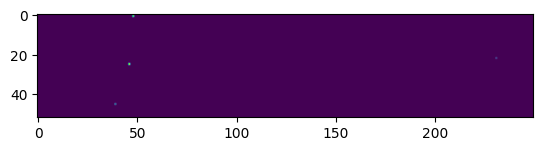

In [8]:
# Assuming you have already trained the model and stored it in the variable 'model'

# Get the feature importances
feature_importances = model.feature_importances_
feature_importances = feature_importances.reshape(52, -1)

plt.imshow(feature_importances)


In [13]:
model = XGBClassifier()
model.random_state = seed

result,model = train_model_using_loocv(avg_pretreatment_data, pretreatment_label, model)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7385 | 0.0667 | 0.9400 | 0.1053 |



In [30]:
def normalize(data):
    print(f'data.shape -> {data.shape}')
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        # Calculate the mean and standard deviation for the current subject
        mean = np.mean(data[i, :])
        std = np.std(data[i, :])

        # Perform z-normalization for the current subject
        normalized_data[i, :] = (data[i, :] - mean) / std
    return normalized_data
def li_svm_compute_10_fetures(hb, index_start=10, index_end=70):

    hb_task = hb[:, :, index_start:index_end]

    # 1. Integral Raw
    feature_1 = normalize(np.sum(hb_task, axis=2))
    # print(f' feature_1 - {feature_1.shape}')

    # 2. Integral Positive
    feature_2 = normalize(np.sum(np.where(hb_task < 0, 0, hb_task), axis=2))
    # print(f'feature_2 - {feature_2.shape}')

    # 3. Integral Zero-Norm
    feature_3 = normalize(np.sum(hb_task - np.min(hb_task, axis=(0, 1, 2)), axis=2))
    # print(f'feature_3 - {feature_3.shape}')

    # 4. Integral Absolute
    feature_4 = normalize(np.sum(np.abs(hb_task), axis=2))
    print(f'feature_4 - {feature_4.shape}')

    # 5. Integral (CUM)
    cum_hb_task = np.cumsum(hb_task, axis=2)
    feature_5 = normalize(np.sum(cum_hb_task, axis=2))
    # print(f'feature_5 - {feature_5.shape}')

    # 6. Integral (CUM) Positive
    cum_hb_task = np.cumsum(hb_task, axis=2)
    cum_hb_task = np.where(cum_hb_task < 0, 0, cum_hb_task)
    feature_6 = normalize(np.sum(cum_hb_task, axis=2))
    # print(f'feature_6 - {feature_6.shape}')

    # 7. Integral (CUM) Zero-Norm
    cum_hb_task = np.cumsum(hb_task, axis=2)
    cum_hb_task = cum_hb_task - np.min(cum_hb_task, axis=(0, 1, 2))
    feature_7 = normalize(np.sum(cum_hb_task, axis=2))
    # print(f'feature_7 - {feature_7.shape}')

    # 8. Integral (CUM) Absolute
    cum_hb_task = np.cumsum(hb_task, axis=2)
    cum_hb_task = np.abs(cum_hb_task)
    feature_8 = normalize(np.sum(cum_hb_task, axis=2))
    # print(f'feature_8 - {feature_8.shape}')

    # 9. Centroid (CUM) Positive
    cum_hb_task = np.cumsum(hb_task, axis=2)
    cum_hb_task = np.abs(cum_hb_task)
    hb_task_sum = np.sum(cum_hb_task, axis=2)/2
    abs_cum_hb_task_minus_sum_2 = np.abs(
        cum_hb_task - hb_task_sum[:, :, np.newaxis])
    feature_9 = normalize(np.argmin(abs_cum_hb_task_minus_sum_2, axis=2))
    # print(f'feature_9 - {feature_9.shape}')

    # 10. Centroid (CUM) Zero-Norm
    cum_hb_task = np.cumsum(hb_task, axis=2)
    cum_hb_task = cum_hb_task - np.min(cum_hb_task, axis=(0, 1, 2))
    hb_task_sum = np.sum(cum_hb_task, axis=2)/2
    abs_cum_hb_task_minus_sum_2 = np.abs(
        cum_hb_task - hb_task_sum[:, :, np.newaxis])
    feature_10 = normalize(np.argmin(abs_cum_hb_task_minus_sum_2, axis=2))
    # print(f'feature_10 - {feature_10.shape}')

    feature_sum = np.concatenate((feature_1[:,:,np.newaxis],
                                feature_2[:,:,np.newaxis],
                                feature_3[:,:,np.newaxis],
                                feature_4[:,:,np.newaxis],
                                feature_5[:,:,np.newaxis],
                                feature_6[:,:,np.newaxis],
                                feature_7[:,:,np.newaxis],
                                feature_8[:,:,np.newaxis],
                                feature_9[:,:,np.newaxis],
                                feature_10[:,:,np.newaxis]), axis=2)

    res = np.reshape(feature_sum, (feature_sum.shape[0], -1))
    # print(res.shape)
    return res





def extract_hb_core_temporal_features(Hb):
    # 1.Average
    feature_average = np.mean(Hb, axis=2)

    # 2.Maximum
    feature_maximum = np.max(Hb, axis=2)

    # 3.Minimum
    feature_minimum = np.min(Hb, axis=2)

    # 4.Variance
    feature_variance = np.var(Hb, axis=2)

    # 5.Skewness
    feature_skewness = np.mean((Hb - feature_average[:, :, np.newaxis]) ** 3)
    feature_skewness /= np.std(Hb, axis=2) ** 3

    # 6.Kurtosis
    n = Hb.shape[-1]

    # Standard deviation of the data
    std_dev = np.std(Hb, axis=2)

    # Calculate the fourth moment
    fourth_moment = np.mean(
        (Hb - feature_average[:, :, np.newaxis]) ** 4, axis=2)

    # Calculate the kurtosis
    feature_kurtosis = (n * (n + 1) * fourth_moment) / ((n - 1) * (n - 2)
                                                        * (n - 3) * (std_dev ** 4)) - (3 * (n - 1) ** 2) / ((n - 2) * (n - 3))

    all_feature = np.concatenate((feature_average[:, :, np.newaxis],
                                  feature_maximum[:, :, np.newaxis],
                                  feature_minimum[:, :, np.newaxis],
                                  feature_variance[:, :, np.newaxis],
                                  feature_skewness[:, :, np.newaxis],
                                  feature_kurtosis[:, :, np.newaxis]), axis=2)
    return all_feature




def yu_feature_extract(input, index_start = 10, index_end = 70, hbo_type = 0, hbr_type = 1):
    m = input.shape[-1]//2
    input = np.concatenate((input[...,:m,np.newaxis], input[...,m:,np.newaxis]), axis=-1)
    feature_silent_1_hbo = extract_hb_core_temporal_features(
        input[:, :, :index_start, hbo_type])
    feature_silent_1_hbr = extract_hb_core_temporal_features(
        input[:, :, :index_start, hbr_type])

    feature_task_hbo = extract_hb_core_temporal_features(
        input[:, :, index_start:index_end, hbo_type])
    feature_task_hbr = extract_hb_core_temporal_features(
        input[:, :, index_start:index_end, hbr_type])

    feature_silent_2_hbo = extract_hb_core_temporal_features(
        input[:, :, index_end:, hbo_type])
    feature_silent_2_hbr = extract_hb_core_temporal_features(
        input[:, :, index_end:, hbr_type])

    output = np.concatenate(
        (feature_silent_1_hbo, feature_task_hbo, feature_silent_2_hbo, feature_silent_1_hbr, feature_task_hbr, feature_silent_2_hbr), axis=2)
    return output




In [46]:
tmp = normalize(yu_feature)
print(np.max(tmp))
tmp = np.nan_to_num(tmp)

data.shape -> (65, 52, 36)
nan


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_82591/241656249.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_data[i, :] = (data[i, :] - mean) / std


In [47]:
print("Using selected features to do the prediction")
TF_10_features = get_10_features(pretreatment_data[...,:1250], index_start=100, task_duration=600)
zhifei_TF_10_features = li_svm_compute_10_fetures(pretreatment_data[...,:1250], index_start=100, index_end=700)
yu_feature = yu_feature_extract(pretreatment_data, index_start=100, index_end=700, hbo_type=0, hbr_type=1)
yu_feature = np.nan_to_num(yu_feature)

# DATA = np.concatenate((TF_10_features, zhifei_TF_10_features), axis=1)
DATA = tmp
def check_result(data, label):
    data = np.reshape(data, (data.shape[0], -1))

    print("Start finding the best seed")
    best_seed = 0
    best_f1 = 0 
    for _ in range(10):
        seed = int(time.time())
        print(f'current seed: {seed}')
        
        params = {
            'objective': 'binary:logistic',  # for binary classification
            'eval_metric': 'logloss',        # evaluation metric
            'max_depth': np.random.choice([3, 4, 5, 6, 7, 8, 9, 10]),                  # maximum depth of trees
            'learning_rate': np.random.choice([0.01, 0.05, 0.1, 0.2, 0.3]),            # learning rate
            'earlystopping_rounds': np.random.choice([10, 20, 30, 40, 50]),     # early stoping
            'n_estimators': np.random.choice([50, 100, 150, 200, 250, 300, 400, 500])
        }
        model = XGBClassifier(
            objective=params['objective'], max_depth=params['max_depth'], learning_rate=params['learning_rate'], n_estimators=params['n_estimators'])

        # model = DecisionTreeClassifier()
        model.random_state = seed

        result,model = train_model_using_loocv(data, label, model)
        res_metrics = get_metrics(result[:, 1], result[:, 0])
        if res_metrics[-1] > best_f1: 
            best_f1 = res_metrics[-1]
            best_seed = seed
        print_md_table('Decision Tree', 'test', res_metrics)
    return best_seed

check_result(DATA, pretreatment_label)

Using selected features to do the prediction
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
feature_4 - (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)
data.shape -> (65, 52)


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_82591/241656249.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_data[i, :] = (data[i, :] - mean) / std
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_82591/241656249.py:11: RuntimeWarning: invalid value encountered in cast
  normalized_data[i, :] = (data[i, :] - mean) / std
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_82591/241656249.py:108: RuntimeWarning: divide by zero encountered in divide
  feature_skewness /= np.std(Hb, axis=2) ** 3
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_82591/241656249.py:121: RuntimeWarning: invalid value encountered in divide
  feature_kurtosis = (n * (n + 1) * fourth_moment) / ((n - 1) * (n - 2)


Start finding the best seed
current seed: 1710234446

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7231 | 0.0000 | 0.9400 | 0.0000 |

current seed: 1710234454

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.6923 | 0.0000 | 0.9000 | 0.0000 |

current seed: 1710234460

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7385 | 0.0000 | 0.9600 | 0.0000 |

current seed: 1710234488

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7077 | 0.0000 | 0.9200 | 0.0000 |

current seed: 171023

0

In [84]:
print("Using XGBoost is unable to predicti Treatment Response using time series data")

print(f'now using average signal and try different XGBoost models to see if the performance can be improved')


avg_hbo_hbr = average_signal_and_reshape(pretreatment_data, numof_avgpoint=20)

all_seed = []
all_f1 = []
print("Start finding the best seed")
best_seed = 0
best_f1 = 0 
n_estimators_arr = [500]
best_params = {}
for n_estimators in n_estimators_arr:
    
    seed = int(time.time())
    print(f'current seed: {seed}, n_estimators: {n_estimators}')
    
    model = XGBClassifier(eta=0.8, n_estimators=n_estimators)

    model.random_state = seed
    result,model = train_model_using_loocv(avg_hbo_hbr, pretreatment_label, model)
    res_metrics = get_metrics(result[:, 1], result[:, 0])
    if res_metrics[-1] > best_f1: 
        best_f1 = res_metrics[-1]
        best_seed = seed
    all_seed.append(seed)
    all_f1.append(res_metrics[-1])
    print_md_table('XGBoost', 'test', res_metrics)

Using XGBoost is unable to predicti Treatment Response 
now using average signal and try different XGBoost models to see if the performance can be improved
The data shape length is 3.
Start finding the best seed
current seed: 1710231111, n_estimators: 500

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| XGBoost | test | 0.7846 | 0.3333 | 0.9200 | 0.4167 |



In [55]:
print("Try using FC")



best_f1: 0, best_seed: 0


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_28627/1782615628.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df['current seed'], df['F1 Score'], 'o-', color='green', linestyle=(0, (5, 10)), linewidth=2)


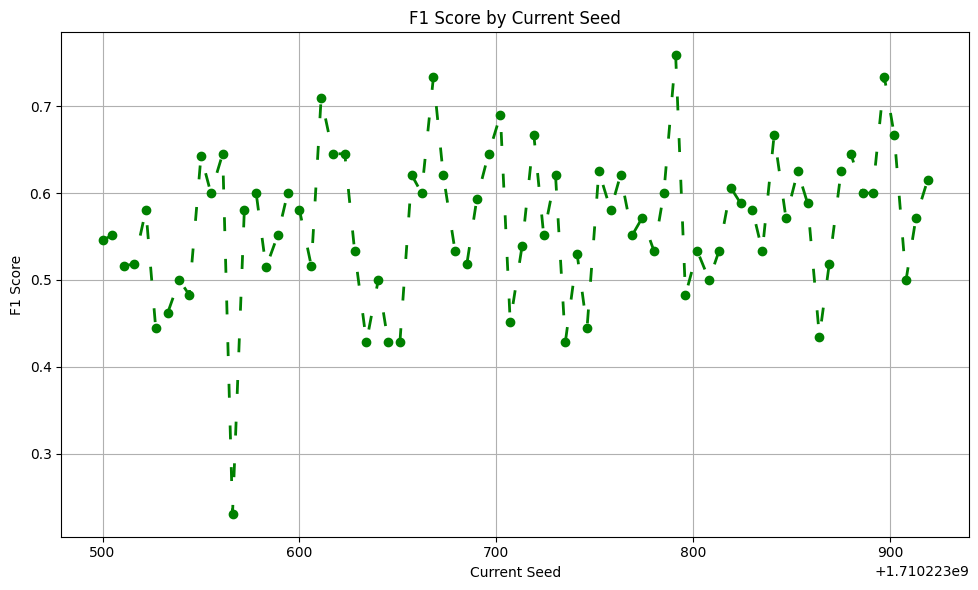

In [54]:

import pandas as pd
import matplotlib.pyplot as plt

# Construct the DataFrame
data = {
    'current seed': [
        1710223500, 1710223505, 1710223511, 1710223516, 1710223522, 1710223527,
        1710223533, 1710223539, 1710223544, 1710223550, 1710223555, 1710223561,
        1710223566, 1710223572, 1710223578, 1710223583, 1710223589, 1710223594,
        1710223600, 1710223606, 1710223611, 1710223617, 1710223623, 1710223628,
        1710223634, 1710223640, 1710223645, 1710223651, 1710223657, 1710223662,
        1710223668, 1710223673, 1710223679, 1710223685, 1710223690, 1710223696,
        1710223702, 1710223707, 1710223713, 1710223719, 1710223724, 1710223730,
        1710223735, 1710223741, 1710223746, 1710223752, 1710223758, 1710223763,
        1710223769, 1710223774, 1710223780, 1710223785, 1710223791, 1710223796,
        1710223802, 1710223808, 1710223813, 1710223819, 1710223824, 1710223830,
        1710223835, 1710223841, 1710223847, 1710223853, 1710223858, 1710223864,
        1710223869, 1710223875, 1710223880, 1710223886, 1710223891, 1710223897,
        1710223902, 1710223908, 1710223913, 1710223919
    ],
    'F1 Score': [
        0.5455, 0.5517, 0.5161, 0.5185, 0.5806, 0.4444, 0.4615, 0.5000, 0.4828, 0.6429, 0.6000,
        0.6452, 0.2308, 0.5806, 0.6000, 0.5143, 0.5517, 0.6000, 0.5806, 0.5161, 0.7097, 0.6452,
        0.6452, 0.5333, 0.4286, 0.5000, 0.4286, 0.4286, 0.6207, 0.6000, 0.7333, 0.6207, 0.5333,
        0.5185, 0.5926, 0.6452, 0.6897, 0.4516, 0.5385, 0.6667, 0.5517, 0.6207, 0.4286, 0.5294,
        0.4444, 0.6250, 0.5806, 0.6207, 0.5517, 0.5714, 0.5333, 0.6000, 0.7586, 0.4828, 0.5333,
        0.5000, 0.5333, 0.6061, 0.5882, 0.5806, 0.5333, 0.6667, 0.5714, 0.6250, 0.5882, 0.4348,
        0.5185, 0.6250, 0.6452, 0.6000, 0.6000, 0.7333, 0.6667, 0.5000, 0.5714, 0.6154
    ]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))

# Improving the aesthetics of the plot
plt.title('F1 Score by Current Seed')
plt.xlabel('Current Seed')
plt.ylabel('F1 Score')
plt.grid(True)
plt.tight_layout()

# Since we want to replicate the style of the uploaded image, we should make the line dashed.
# The color in the image looks like a solid green, so we will keep the same color.
# However, to make sure the user can see the exact line style, we can adjust the dashes to be more visible.

plt.plot(df['current seed'], df['F1 Score'], 'o-', color='green', linestyle=(0, (5, 10)), linewidth=2)

# Show the plot
plt.show()

In [63]:
df['current seed'][np.argmax(df['F1 Score'])]

1710223791

In [17]:
print('Now define XGBoost to see if it can improve the performance')
xgboost = XGBClassifier()
result,xgboost = train_model_using_loocv(pretreatment_data, pretreatment_label, xgboost)
res_metrics = get_metrics(result[:, 1], result[:, 0])
print_md_table('Decision Tree', 'test', res_metrics)

Now define XGBoost to see if it can improve the performance

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.7538 | 0.0000 | 0.9800 | 0.0000 |
